In [14]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

def scrape_linkedin_locations(profile_urls):
    options = webdriver.ChromeOptions()
    options.add_argument("--start-maximized")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get("https://www.linkedin.com/login")
    print("\n⚠️ Please log in to LinkedIn manually within 30 seconds...")
    time.sleep(30)

    scraped = {}
    for url in profile_urls:
        driver.get(url)
        time.sleep(5)
        try:
            location = driver.find_element(By.CSS_SELECTOR, ".text-body-small.inline.t-black--light.break-words").text
        except:
            location = None
        scraped[url] = location
        print(f"✅ Scraped: {url} | 📍 {location}")
    driver.quit()
    return scraped

# ========== USAGE ==========
df = pd.read_csv("Dummy Dataset Final.csv")
if "Linkedin" in df.columns:
    if not "LinkedIn_Location" in df.columns or df["LinkedIn_Location"].isna().all():
        linkedin_urls = df["Linkedin"].dropna().tolist()
        scraped_map = scrape_linkedin_locations(linkedin_urls)
        df["LinkedIn_Location"] = df["Linkedin"].map(scraped_map)
        df.to_csv("Final Dataset with LinkedIn.csv", index=False)
    else:
        print("✅ LinkedIn data already scraped.")
else:
    df["LinkedIn_Location"] = None
    print("⚠️ 'Linkedin' column not found.")

# Save the DataFrame after scraping LinkedIn locations
df.to_csv("Final Dataset with LinkedIn.csv", index=False)
print("✅ LinkedIn-enhanced dataset saved as 'Final Dataset with LinkedIn.csv'")


⚠️ Please log in to LinkedIn manually within 30 seconds...
✅ Scraped: https://www.linkedin.com/in/shraddhan-singhai-b11786282/ | 📍 Ahmedabad, Gujarat, India
✅ Scraped: https://www.linkedin.com/in/avani-goyal-4b0799289/ | 📍 Pune, Maharashtra, India
✅ Scraped: https://www.linkedin.com/in/mansi-gangwar-aa9b53237/ | 📍 Bareilly, Uttar Pradesh, India
✅ Scraped: https://www.linkedin.com/in/vansh-bhandari-869118281/ | 📍 Jaipur, Rajasthan, India
✅ Scraped: https://www.linkedin.com/in/disha-gokhale/ | 📍 Nagpur, Maharashtra, India
✅ Scraped: https://www.linkedin.com/in/sgarg | 📍 San Francisco Bay Area
✅ Scraped: https://www.linkedin.com/in/iswaminathan | 📍 None
✅ Scraped: https://www.linkedin.com/in/zainramachandran | 📍 None
✅ Scraped: https://www.linkedin.com/in/rati85 | 📍 None
✅ Scraped: https://www.linkedin.com/in/krishcheema | 📍 None
✅ Scraped: https://www.linkedin.com/in/piya52 | 📍 None
✅ Scraped: https://www.linkedin.com/in/daminimadan | 📍 None
✅ Scraped: https://www.linkedin.com/in/rhea15

In [15]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from typing import TypedDict, List, Dict
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END

In [16]:
GROQ_API_KEY = "YOUR_GROQ_API_KEY"

llm = ChatGroq(
    temperature=0.1, 
    model_name="llama3-70b-8192",
    api_key=GROQ_API_KEY
)

In [17]:
class LocationAnalysisState(TypedDict):
    input_data: Dict[str, str]
    agent1_output: str
    agent2_output: str
    agent3_output: str
    final_output: str
    logs: List[str]


In [18]:
def agent_1_static_verifier(state: LocationAnalysisState) -> LocationAnalysisState:
    prompt = """
    You are Agent 1: The Static Verifier.

    Analyze the following static location data:
    - Account Opening Branch
    - DL Number
    - Vehicle Number
    - Address
    - Phone Prefix

    For each unique city/state you find in these fields, assign scores as follows:
    - Branch: +2
    - DL: +2
    - Vehicle: +1.5
    - Address: +1.5
    - Phone Prefix: +0.5

    Output ONLY this format:
    City, State - TotalScore
    ...

    Then write:
    Final Chosen Home Location: City, State
    ---
    Data:
    {input_data}
    """
    input_data_str = "\n".join([f"- {k}: {v}" for k, v in state["input_data"].items()])
    response = llm.invoke(prompt.format(input_data=input_data_str))
    log_message = f"--- Agent 1 ---\n{response.content}"
    return {"agent1_output": response.content, "logs": state["logs"] + [log_message]}

In [19]:
def agent_2_activity_verifier(state: LocationAnalysisState) -> LocationAnalysisState:
    prompt = """
    You are Agent 2: The Activity Verifier.

    Analyze the following activity-based location data:
    - ATM Location
    - UPI Location
    - LinkedIn Location
    - Frequent / Last Location

    For each unique city/state found, assign scores:
    - ATM: +3
    - UPI: +2.5
    - LinkedIn: +1.5
    - Frequent/Last: +1

    Output ONLY this format:
    City, State - TotalScore
    ...

    Then write:
    Final Chosen Last Known Location: City, State
    ---
    Data:
    {input_data}
    """
    input_data_str = "\n".join([f"- {k}: {v}" for k, v in state["input_data"].items()])
    response = llm.invoke(prompt.format(input_data=input_data_str))
    log_message = f"--- Agent 2 ---\n{response.content}"
    return {"agent2_output": response.content, "logs": state["logs"] + [log_message]}

In [20]:
def agent_3_cross_validator(state: LocationAnalysisState) -> LocationAnalysisState:
    prompt = """
    You are Agent 3: The Cross Validator.

    You have received these location predictions:
    Agent 1 (Home Location):
    {agent1_output}

    Agent 2 (Last Known Location):
    {agent2_output}

    Your job:
    - Apply -2 penalty per state conflict
    - Note if DL + Branch both missing
    - Note if 3+ distinct cities exist
    - Check if home and last known are in same state
    - Give raw final score for home location after penalty

    Output:
    Final Predicted Location: City, State
    Last Known Location: City, State
    Raw Score: <value>
    Flags: <missing critical/multiple cities/etc>
    """
    response = llm.invoke(prompt.format(
        agent1_output=state["agent1_output"],
        agent2_output=state["agent2_output"]
    ))
    log_message = f"--- Agent 3 ---\n{response.content}"
    return {"agent3_output": response.content, "logs": state["logs"] + [log_message]}

In [21]:
def agent_4_scoring_evaluator(state: LocationAnalysisState) -> LocationAnalysisState:
    prompt = """
    You are Agent 4: The Final Scorer.

    Based on this input:
    {agent3_output}

    Rules:
    - High: score ≥ 7
    - Medium: 4 ≤ score < 7
    - Low: score < 4
    - Low or 3+ cities or critical missing → append "(Manual Review Needed)"
    - +0.5 bonus if home and last known in same state

    Output ONLY 3 lines:
    Final Predicted Location: City, State
    Prediction Confidence: High/Medium/Low
    Last Known Location: City, State
    """
    response = llm.invoke(prompt.format(agent3_output=state["agent3_output"]))
    final_output = response.content.strip()
    log_message = f"--- Agent 4 ---\n{final_output}"
    return {"final_output": final_output, "logs": state["logs"] + [log_message]}

In [22]:
workflow = StateGraph(LocationAnalysisState)
workflow.add_node("agent_1", agent_1_static_verifier)
workflow.add_node("agent_2", agent_2_activity_verifier)
workflow.add_node("agent_3", agent_3_cross_validator)
workflow.add_node("agent_4", agent_4_scoring_evaluator)
workflow.set_entry_point("agent_1")
workflow.add_edge("agent_1", "agent_2")
workflow.add_edge("agent_2", "agent_3")
workflow.add_edge("agent_3", "agent_4")
workflow.add_edge("agent_4", END)
app = workflow.compile()

In [23]:
def parse_final_output(output_text: str):
    if not output_text:
        return {"final_location": "Parse Error", "confidence": "N/A", "last_known": "Parse Error"}
    final_loc = re.search(r"Final Predicted Location:\s*(.*)", output_text, re.I)
    confidence = re.search(r"Prediction Confidence:\s*(.*)", output_text, re.I)
    last_known = re.search(r"Last Known Location:\s*(.*)", output_text, re.I)
    return {
        "final_location": final_loc.group(1).strip() if final_loc else "Not Found",
        "confidence": confidence.group(1).strip() if confidence else "Not Found",
        "last_known": last_known.group(1).strip() if last_known else "Not Found",
    }


In [24]:
def print_summary_report(name, agent1_output, agent2_output, final_info):
    print("\n--- Summary Report ---")
    print(f"Person: {name}")
    print("\nDetected Locations:")

    # Extract and print all lines that look like: City, State - score
    for line in (agent1_output + "\n" + agent2_output).splitlines():
        if re.match(r"^[A-Za-z\s]+,\s*[A-Za-z\s]+ - \d+(\.\d+)?$", line.strip()):
            print("  " + line.strip())

    # Extract chosen locations
    chosen_home = re.search(r"Final Chosen Home Location:\s*(.*)", agent1_output)
    chosen_last = re.search(r"Final Chosen Last Known Location:\s*(.*)", agent2_output)

    print("\nChosen Home:", chosen_home.group(1).strip() if chosen_home else "Unknown")
    print("Chosen Last Known:", chosen_last.group(1).strip() if chosen_last else "Unknown")
    print("Final Prediction:", final_info["final_location"])
    print("Confidence:", final_info["confidence"])
    print("-" * 26)


==================== [1/35] Shraddhan Sharad ====================

--- Summary Report ---
Person: Shraddhan Sharad

Detected Locations:

Chosen Home: Jaipur, Rajasthan
Chosen Last Known: Jaipur, Rajasthan
Final Prediction: Jaipur, Rajasthan
Confidence: Low
--------------------------

==================== [2/35] Avani ====================

--- Summary Report ---
Person: Avani

Detected Locations:
  Pune, Maharashtra - 7.5
  Guwahati, Assam - 2

Chosen Home: Pune, Maharashtra
Chosen Last Known: Pune, Maharashtra
Final Prediction: Pune, Maharashtra
Confidence: High
--------------------------

==================== [3/35] Mansi  ====================

--- Summary Report ---
Person: Mansi 

Detected Locations:
  Bareilly, Uttar Pradesh - 4.5

Chosen Home: Bareilly, Uttar Pradesh
Chosen Last Known: Bareilly, Uttar Pradesh
Final Prediction: Bareilly, Uttar Pradesh
Confidence: High
--------------------------

==================== [4/35] Vansh ====================

--- Summary Report ---
Person:

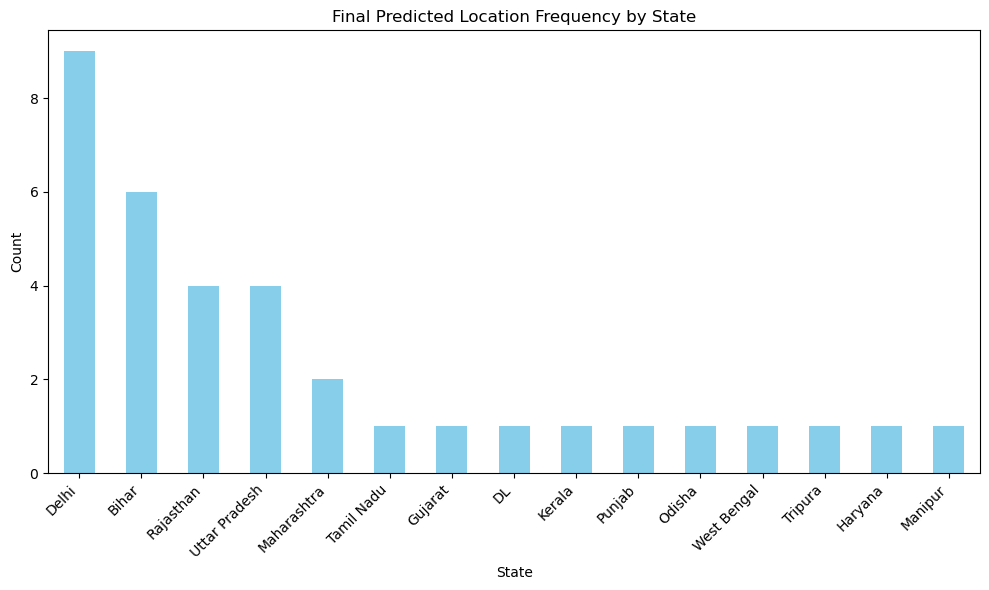

In [25]:
if __name__ == "__main__":
    location_fields = [
        'Address', 'Ph_no. ', 'DL Number', 'LinkedIn_Location',
        'Account Opening Branch Code (Last Six Characters of IFSC Code)',
        'Frequent Location', 'Last location', 'UPI Location', 'Vehicle Number',
        'ATM Transaction History', 'Instagram Location Tags'
    ]
    
    try:
        df = pd.read_csv("Final Dataset with LinkedIn.csv")
    except FileNotFoundError:
        print("ERROR: 'Dummy Dataset Final.csv' not found.")
        exit()

    df["Final_Predicted_Location"] = None
    df["Prediction_Confidence"] = None
    df["Last_Known_Location"] = None
    df["Agent_Reasoning_Log"] = None

    state_counter = {}

    name_col = 'First_Name_Middle_Name' if 'First_Name_Middle_Name' in df.columns else df.columns[0]

    for index, row in df.iterrows():
        print(f"\n{'='*20} [{index + 1}/{len(df)}] {row[name_col]} {'='*20}")
        fields_to_analyze = {
            col: str(row[col]) for col in location_fields
            if col in df.columns and pd.notnull(row[col]) and str(row[col]).strip()
        }

        if not fields_to_analyze:
            print("  No location data found. Skipping.")
            continue

        initial_state = {"input_data": fields_to_analyze, "logs": []}
        final_state = app.invoke(initial_state)

        parsed = parse_final_output(final_state.get("final_output", ""))
        df.at[index, "Final_Predicted_Location"] = parsed["final_location"]
        df.at[index, "Prediction_Confidence"] = parsed["confidence"]
        df.at[index, "Last_Known_Location"] = parsed["last_known"]
        df.at[index, "Agent_Reasoning_Log"] = "\n\n".join(final_state.get("logs", []))

        # Print short report
        print_summary_report(
            name=row[name_col],
            agent1_output=final_state["agent1_output"],
            agent2_output=final_state["agent2_output"],
            final_info=parsed
        )

        # Track state frequency
        if parsed["final_location"] and parsed["final_location"] != "Not Found":
            state = parsed["final_location"].split(",")[-1].strip()
            state_counter[state] = state_counter.get(state, 0) + 1

    output_file = "multi_agent_location_predictions.csv"
    df.to_csv(output_file, index=False)
    print(f"\n✅ Results saved to: {output_file}")

    # --- PLOT STATE-WISE BAR CHART ---
    if state_counter:
        state_series = pd.Series(state_counter).sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        state_series.plot(kind='bar', color='skyblue')
        plt.title("Final Predicted Location Frequency by State")
        plt.xlabel("State")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()